In [3]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import pickle
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


<IPython.core.display.Javascript object>


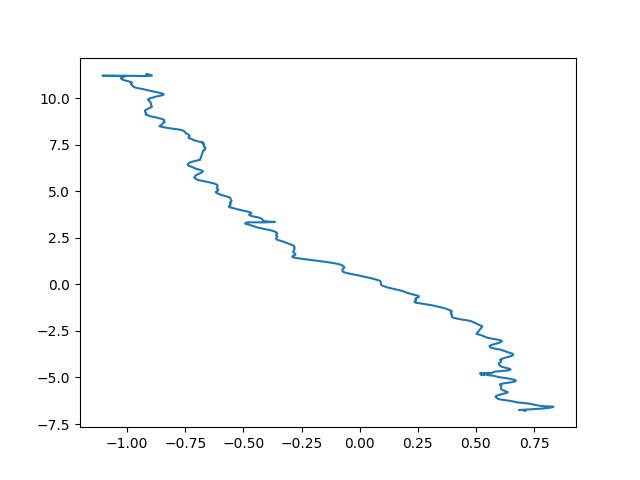

In [4]:
#TIERS

filename = 'C:/TIERS/forest01_optitrack.csv'
# filename = 'C:/TIERS/forest02_optitrack.csv'

data = np.loadtxt(filename, delimiter=",", usecols = range(11))
# [timestamp, pose.position.x,  pose.position.y,  pose.position.z, 
#   roll, pitch, yaw, pose.orientation.x, pose.orientation.y, pose.orientation.z, 
#   pose.orientation.w ]

# print(np.diff(data, axis = 0))
gt = data[:,1:4]
# print(gt)

fig, ax = plt.subplots()
ax.plot(gt[:,0], gt[:,1])


In [5]:
#CODD
import h5py

# filename = 'C:/CODD/data/m1v7p7s769.hdf5'
# filename = 'C:/CODD/data/m5v10p6s31.hdf5' #turn on country road
# filename = 'C:/CODD/data/m2v7p3s333.hdf5'
filename = 'C:/CODD/data/m10v11p6s30.hdf5' #wide road, traffic and palm trees

vidx = 0

with h5py.File(filename, 'r') as hf:
#     pcls = hf['point_cloud'][:]
    #[frames, vehicles, points_per_cloud, 4]
    pcls = hf['point_cloud'][:, vidx ,: , :3]
    #[frames, points_per_cloud, rgb]
    
#     pose = hf['lidar_pose'][:]
    #[frames, vehicles, (x,y,z, rotx, roty, rotz)]
    pose = hf['lidar_pose'][:, vidx, :]
    
    vbb = hf['vehicle_boundingbox'][:, vidx, :]
    
print(np.shape(pcls))
print(np.shape(pose))
print(np.shape(vbb))

#these are the same
# print(pose[1,:])
# print(vbb[1,:])


(125, 50000, 3)
(125, 6)
(125, 8)


<IPython.core.display.Javascript object>


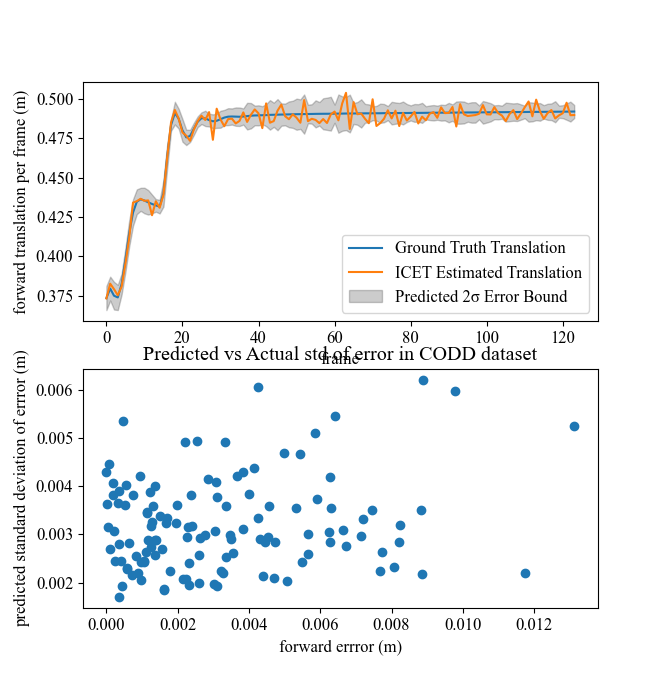

(124,)
correlation: 
 [[1.         0.18925344]
 [0.18925344 1.        ]]


In [35]:

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(2,1)

component = 0 #fwd translation 
# component = 5 #yaw

vel = np.diff(pose, axis = 0)

vf = np.sqrt(vel[:,0]**2 + vel[:,1]**2 ) # if plotting forward translation
# vf = vel[:,4]#*np.pi/180 #for yaw

# # #test
# component = 1
# # vf = -vel[:,5] 
# vf = vf*0

ax[0].plot(vf, label = 'Ground Truth Translation')
# ax.plot(np.diff(pose, axis = 0)[:,4])  
# ax.scatter(pose[:,0], pose[:,1])  
print(np.shape(vf))

estimates = np.loadtxt('ICET_estimates_CODD_v6.txt') #123
pred_stds = np.loadtxt('ICET_pred_stds_CODD_v6.txt')
estimates[:,3:] = estimates[:,3:]*180/np.pi 
pred_stds[:,3:] = pred_stds[:,3:]*180/np.pi 

# estimates = np.loadtxt('ICET_estimates_CODD_v4.txt') #20
# pred_stds = np.loadtxt('ICET_pred_stds_CODD_v4.txt')
# vf = vf[:23]

# print(estimates[:,0])
ax[0].plot(estimates[:,component], label = "ICET Estimated Translation")
# ax[0].plot(estimates[:,0] + pred_stds[:,0], color = [0,0,0], alpha = 0.1)
# ax[0].plot(estimates[:,0] - pred_stds[:,0], color = [0,0,0], alpha = 0.1)
ax[0].fill_between(np.linspace(0,123,124), 
                   vf - 2*pred_stds[:,component], vf + 2*pred_stds[:,component], 
                   color = [0,0,0], alpha = 0.2, label = 'Predicted 2σ Error Bound')
ax[0].set_xlabel("frame")
ax[0].set_ylabel("forward translation per frame (m)")
# ax[0].set_ylabel("change in yaw per frame (deg)")
ax[0].legend(loc = 'lower right')
# ax[0].set_tile("Simple Outlier Rejection")

ferr = vf - estimates[:,0]
# ax[1].plot(abs(ferr))
# ax[1].plot(pred_stds[:,0])
ax[1].scatter(abs(ferr), pred_stds[:,0])
ax[1].set_xlabel("forward errror (m)")
ax[1].set_ylabel("predicted standard deviation of errror (m)")
ax[1].set_title("Predicted vs Actual std of error in CODD dataset")

#correlation between higher predicted std of error and actual higher std of error
print("correlation: \n", np.corrcoef(abs(ferr), pred_stds[:,0]))
# print(np.sum(ferr))
# print(np.sum(vf))

In [13]:
#aiodrive - CMU RI
import pandas as pd
# test = pd.read_pickle(r'C:/aiodrive/control/000000.pkl')
# print(test[0])
# print(len(test))
test = pd.read_pickle(r'C:/aiodrive/velocorr/000000.pkl')
print(test[0])
# print(test[10])
# dat = open(r'C:/aiodrive/lidar_velodyne/000001.bin').read_bytes()
# print(dat)
gps_i = np.loadtxt('C:/aiodrive/gps/000000.txt')
print(gps_i)
gps_i = np.loadtxt('C:/aiodrive/gps/000001.txt')
print(gps_i)
gps_i = np.loadtxt('C:/aiodrive/gps/000002.txt')
print(gps_i)

[[ 9.99723826e-01  1.41205925e-05  2.35004678e-02  2.34897002e-02]
 [ 4.53335213e-06  9.99999685e-01 -7.93715611e-04 -1.39734900e-03]
 [-2.35004716e-02  7.93602944e-04  9.99723511e-01 -1.18903333e-01]
 [-4.85722573e-17  4.16333634e-17  2.77555756e-17  1.00000000e+00]]
[-0.00013423 -0.00047382  0.04371029]
[-0.00013244 -0.00048092  0.04543356]
[-0.00011485 -0.00048143  0.04816017]


In [ ]:
#SynLiDAR
import glob

def read_points(path):
    scan = np.fromfile(path, dtype=np.float32)
    scan = scan.reshape((-1, 4))  # [x,y,z,intensity]
    return scan

def read_label(path):
    label = np.fromfile(path, dtype=np.uint32)
    label = label.reshape((-1))
    return label

f_path = "C:/SynLiDAR/01/velodyne/000007.bin"

scan = read_points(f_path)
# print(np.shape(scan))

label_path = f_path.replace('velodyne', 'labels').replace('bin', 'label')
labels = read_label(label_path)

assert scan.shape[0] == labels.shape[0]

print(labels)
